## Final Baseline Submission: Toxic Language Classification 
**w207 Spring 2018 - Final Project Baseline**

**Team: Paul, Walt, Yisang, Joe**



### Project Description 

Our challenge is to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate.  The toxic language data set is sourced from Wikipedia and available as a public kaggle data set. 

Our goal is to use various machine learning techniques used in class to develop high quality ML models and pipelines.  

Our research deliverables will be the following:
1. Exercise and build upon concepts covered in class and test out the following supervised models:
    a. Regression (LASSO, Logistic)
    b. Naive Bayes
    c. Trees (XGBoost)
    d. Neural Networks MPI
    c. KNN
2. Using stacking/ensembling methods (simple blending)


For the baseline proposal, this file contains a first pass run through from data preprocessing to model evaluation using a regression model pipeline. 

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge




### Data Summary

Our team ingested the Toxic Comments data set and applied custom partitions for internal development and testing. 

In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import string

from subprocess import check_output

# wordcloud
#!conda install -c conda-forge wordcloud
from wordcloud import WordCloud, STOPWORDS

#Image imports
from PIL import Image

#sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer


#xgboost
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)


#scipy imports
from scipy.sparse import hstack

#Visualization imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
#import matplotlib as mp
import seaborn as sns

import matplotlib.gridspec as gridspec 

#NLTK imports
import string

import nltk
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk.tokenize import punkt as punkt
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
stop = stopwords.words('english')

# These imports enable the use of NLTKPreprocessor in an sklearn Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


#scipy imports
from scipy.sparse import hstack

#General imports
import pprint
import time

from collections import Counter


sns.set(style="white", context="talk")

np.random.seed(455)

# target classes
target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### Data Ingestion

In [15]:
# read frames localy through csv
train_df = pd.read_csv("../w207_FinalProject/data/train.csv")
test_df = pd.read_csv("../w207_FinalProject/data/test.csv")

# Random index generator for splitting training data
# Note: Each rerun of cell will create new splits.
randIndexCut = np.random.rand(len(train_df)) < 0.7

#S plit up data
test_data = test_df["comment_text"]
dev_data, dev_labels = train_df[~randIndexCut]["comment_text"], train_df[~randIndexCut][target_names]
train_data, train_labels = train_df[randIndexCut]["comment_text"], train_df[randIndexCut][target_names]

print 'total training observations:', train_df.shape[0]
print 'training data shape:', train_data.shape
print 'training label shape:', train_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', target_names

total training observations: 159571
training data shape: (111906,)
training label shape: (111906, 6)
dev label shape: (47665, 6)
labels names: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


### Exploratory Data Analysis

In [16]:
from PIL import _imagingft

In [17]:
#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


#stopwords = set(STOPWORDS)
#wordcloud = WordCloud(
#                          background_color='white',
#                          stopwords=stopwords,
#                          max_words=200,
#                          max_font_size=40, 
#                          random_state=42
#                         ).generate(" ".join(train_df["comment_text"]))

#print(wordcloud)
#fig = plt.figure(1)
#plt.imshow(wordcloud)
#plt.axis('off')
#plt.show()

### Assessing the Targets

Let's see how imblanced the label set is in order to have a better understanding with the label quality of the given data set. 

NameError: name 'rect' is not defined

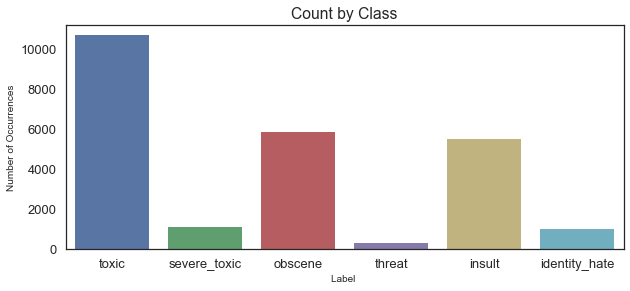

In [18]:

target_counts = train_labels.apply(np.sum,0)

#Plot counts by class in barplot
plt.figure(figsize=(10,4))
ax= sns.barplot(target_counts.index, target_counts.values)
plt.title("Count by Class")
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Label ', fontsize=10)

plt.show()

The data is fairly imbalanced when counting label occurrences. 

Ideas to consider
- Sampling methods
- Custom Cross Validation

### Categorical Analysis

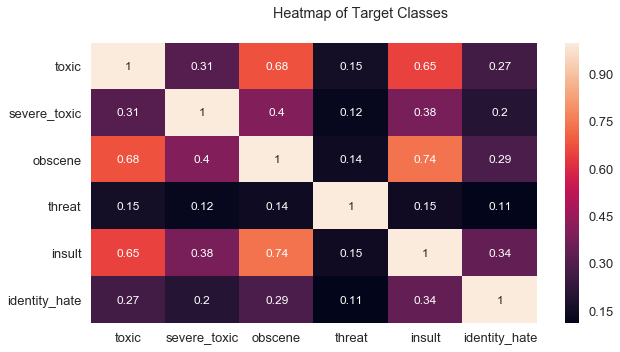

In [19]:
#Heatmap
f, ax_heatmap = plt.subplots(figsize=(10, 5))
f.suptitle('Heatmap of Target Classes')
sns.heatmap(train_labels.corr(), annot=True, ax=ax_heatmap)

In [20]:
#Crosstab

def multiCrossTab(main_col):
    corr_mats=[]
    for other_col in train_labels.columns[:]:
        confusion_matrix = pd.crosstab(train_labels[main_col], train_labels[other_col])
        corr_mats.append(confusion_matrix)
        out = pd.concat(corr_mats,axis=1,keys=train_labels.columns[:])
    return(out.style.highlight_min(axis=0))

for i in target_names:
    display(multiCrossTab(main_col=i))


Some interesting observations:

- Toxic is clearly a subset of Severe Toxic.  So this means that a severe toxic comment is always toxic.  
- Other classes seem to be a subset of toxic barring a few exceptions
- The major takeaway is that these classes are both imbalanced and exhibit highly correlative patterns. 
    - We cannot conventiently assume that classes add up to 1.00 Probability and is thus a multi-label problem. 

### Text Pre-processing
....

In [21]:
nltk.download('stopwords')

class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    """Text preprocessor using NLTK tokenization and Lemmatization

    This class is to be used in an sklean Pipeline, prior to other processers like PCA/LSA/classification
    Attributes:
        lower: A boolean indicating whether text should be lowercased by preprocessor
                default: True
        strip: A boolean indicating whether text should be stripped of surrounding whitespace, underscores and '*'
                default: True
        stopwords: A set of words to be used as stop words and thus ignored during tokenization
                default: built-in English stop words
        punct: A set of punctuation characters that should be ignored
                default: None
        lemmatizer: An object that should be used to lemmatize tokens
    """

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        """Initialize method for NLTKPreprocessor instance

        Simple initialization of specified instance variables:

        Args:
            self 
            stopwords: set of words to ignore as stop words, or a default set for English will be used
            punct: set of punctuation characters to strip, or a default set will be used
            lower: indicator of whether to convert all characters to lowercase, defaults to True
            strip: indicator of whether to strip whitespace, defaults to True

        Returns:
            N/A: instance initializer

        """
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        

    def fit(self, X, y=None):
        """Fit model with X and optional y

        Function exists as implementation of sklearn.BaseEstimator, for use in Pipeline.
        This is a NO-OP, simply for complying with interface.

        Args:
            self 
            X: independent variable
            y: dependent variable
            
        Returns:
            NLTKPreprocessor: self
        """
        return self

    def inverse_transform(self, X):
        """Function exists as implementation of sklearn.BaseEstimator, for use in Pipeline.
        This is simply for complying with interface.

        Args:
            self 
            X: array-like, input documents
            
        Returns:
            string: joined documents
        """
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        """Transform input X to produce output to be processed by next element in sklearn Pipeline

        This triggers the tokenization/lemmatization of the source documents.
        This is invoked by the sklearn Pipeline.

        Args:
            self 
            X: input documents to be tokenized
            
        Returns:
            list: tokenized documents reduced to simplest lemma form
        """
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    
    def tokenize(self, document):
        """Tokenize an input document, converting from a block of text into sentences, into tagged tokens,
        generating a set of lemmas.

        This method does the preprocessing work of sentence-based tokenization and then reduces words to lemmas

        Args:
            self 
            X: independent variable
            y: dependent variable
            
        Returns:
            NLTKPreprocessor: self
        """
        # Break the document into sentences
        for sent in sent_tokenize(unicode(document,'utf-8')):

            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

                
    def lemmatize(self, token, tag):
        """Convert a token into the appropriate lemma

        Method uses the NLTK WordNetLemmatizer for part-of-speech tag-based lemmatization of words.

        Args:
            self 
            token: input word
            tag: part-of-speech tag
            
        Returns:
            string: lemma
        """
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

def identity(arg):
    """
        Simple identity function works as a passthrough.
    """
    return arg

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joseph/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Final Text Processing Method
This block uses the NLTKPreprocessor to tokenize the input data and then the TfidfVectorizer to vectorize it. The NLTKPreprocessor will ignore English stop words and will lemmatize where possible. The vectorizer ignores words occuring in fewer than 5 documents, which sufficed to reduce the size of the words vector significantly. Also, the vectorizer will limit the total features (words) to 30,000, prioritizing the most valuable ones with highest TF-IDF score.

Note that in this case the tokenization available by default in TfidfVectorizer is disabled, since that is handled by the NLTKPreprocessor. This made it clear that tokenization is by far more expensive (time) than vectorization.

In [22]:
pp = pprint.PrettyPrinter(indent=4)

np.random.seed(455)

# This preprocessor will be used to process data prior to vectorization
nltkPreprocessor = NLTKPreprocessor()
    
# Note that this vectorizer is created with a passthru tokenizer(identity), no preprocessor and no lowercasing
# This is to account for the NLTKPreprocessor already taking care of these.
tfidfVector = TfidfVectorizer(ngram_range=(1,1), min_df=5, max_features=30000,
                              tokenizer=identity, preprocessor=None, lowercase=False)

# Reduce training data from list of documents to list of bags of lemmatized tokens
print "Starting final preprocessing of training data..."
start_train_preproc = time.time()
trainPreprocData = nltkPreprocessor.fit_transform(train_data)
finish_train_preproc = time.time()
print "Completed tokenization/preprocessing of training data in {:.2f} seconds".format((finish_train_preproc-start_train_preproc))

# Reduce training data from list of documents to list of bags of lemmatized tokens
print "Starting final preprocessing of dev data..."
start_test_preproc = time.time()
devPreprocData = nltkPreprocessor.transform(dev_data)
finish_test_preproc = time.time()
print "Completed tokenization/preprocessing of dev data in {:.2f} seconds".format((finish_test_preproc-start_test_preproc))

# Convert training tokens to sparse TF-IDF matrix, with maximum of 15,000 features and mininum df of 5 docs.
print "Starting vectorization of training data..."
start_train_vectors = time.time()
finalTrainCounts = tfidfVector.fit_transform(trainPreprocData)
finish_train_vectors = time.time()
print "Completed vectorization of training data in {:.2f} seconds".format((finish_train_vectors-start_train_vectors))

# Convert dev tokens to sparse TF-IDF matrix, with maximum of 15,000 features and mininum df of 5 docs.
print "Starting vectorization of dev data..."
start_dev_vectors = time.time()
final_dev_Counts = tfidfVector.transform(devPreprocData)
finish_dev_vectors = time.time()
print "Completed vectorization of dev data in {:.2f} seconds".format((finish_dev_vectors-start_dev_vectors))

Starting final preprocessing of training data...
Completed tokenization/preprocessing of training data in 909.80 seconds
Starting final preprocessing of dev data...
Completed tokenization/preprocessing of dev data in 387.76 seconds
Starting vectorization of training data...
Completed vectorization of training data in 4.64 seconds
Starting vectorization of dev data...
Completed vectorization of dev data in 1.69 seconds


### LSA - Latent Semantic Analysis
Principal Component Analysis (PCA) and Latent Semantic Analysis (LSA) are both operations that use Singular Value Decomposition to reduce the dimensionality of a dataset. PCA is applied to a term-covariance matrix, whereas LSA is applied to a term-document matrix. As such, LSA is appropriate for machine learning algorithms using scikit-learn TfidfVectorizer. Additionally PCA, as implemented in scikit-learn, cannot handle the sparse matrices that are produced by such vectorization tools.

In [23]:
# Dimensionality Reduction
#
# With a target of 10% of the features produced by TF-IDF, select the most useful features
target_components = len(tfidfVector.vocabulary_)/10

# Convert training data
svd = TruncatedSVD(n_components=target_components, algorithm='arpack')
print "Starting LSA on train counts with {} components...".format(target_components)
train_start=time.time()
lsaTrainCounts = svd.fit_transform(finalTrainCounts)
train_stop=time.time()
print "Train counts transform took {:.2f} seconds.".format(train_stop-train_start)

# Convert dev data
svd = TruncatedSVD(n_components=target_components, algorithm='arpack')
print "Starting LSA on Dev counts with {} components...".format(target_components)
train_start=time.time()
lsaDevCounts = svd.fit_transform(final_dev_Counts)
train_stop=time.time()
print "Dev counts transform took {:.2f} seconds.".format(train_stop-train_start)

Starting LSA on train counts with 1500 components...
Train counts transform took 341.35 seconds.
Starting LSA on Dev counts with 1500 components...
Dev counts transform took 310.04 seconds.


## Modeling

### Logistic Regression

In [24]:
from sklearn.metrics import auc
# SK-learn libraries for cross validation
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
# Basic Logistic Regression Model/MultiLabel Edition

prediction_output = []
scores_output = []
for name in target_names:
    classifier = LogisticRegression(solver='sag') 
    cv_score = np.mean(cross_val_score(
        classifier, lsaTrainCounts, train_labels[name], cv=3, scoring='roc_auc'))
    scores_output.append(cv_score)
    print('CV score for class {} is {}'.format(name, cv_score))
    classifier.fit(lsaTrainCounts, train_labels[name])
    
    
print("Mean Training ROC_AUC: {}").format(np.mean(scores_output))

CV score for class toxic is 0.962269432935
CV score for class severe_toxic is 0.98416130421
CV score for class obscene is 0.981374819905
CV score for class threat is 0.972323262234
CV score for class insult is 0.970485933953
CV score for class identity_hate is 0.968426037941
Mean Training ROC_AUC: 0.973173465196


#### Testing on Dev Data

In [27]:
from sklearn.metrics import auc, roc_curve
from sklearn import metrics

pred_dt = pd.DataFrame()
scores_dev = []
for name in target_names:
    classifier = LogisticRegression(solver='sag') 
    classifier.fit(lsaTrainCounts, train_labels[name])
    output = classifier.predict(lsaDevCounts)
    fpr, tpr, thresholds = metrics.roc_curve(dev_labels[name], output)
    print('Dev score for class {} is {}'.format(name, metrics.auc(fpr,tpr)))
    scores_dev.append(metrics.auc(fpr,tpr))
    pred_dt[name] = classifier.predict_proba(lsaDevCounts)[:, 1]
    
print("Mean(dev) ROC_AUC: {}").format(np.mean(scores_dev))

Dev score for class toxic is 0.615776140679
Dev score for class severe_toxic is 0.586302585567
Dev score for class obscene is 0.666156587041
Dev score for class threat is 0.5
Dev score for class insult is 0.608567186473
Dev score for class identity_hate is 0.499396825397
Mean(dev) ROC_AUC: 0.579366554193


### XGBoost

In [30]:
from xgboost import XGBClassifier
from sklearn.grid_search import GridSearchCV

# parameter for grid sweep
param_test1 = {
 'max_depth':range(3,10,3),
 'min_child_weight':range(1,6,2)
}

clf_xgboost1 = GridSearchCV(XGBClassifier(learning_rate =0.3, n_estimators=50, max_depth=6,
 min_child_weight=1, gamma=.3, subsample=1.0, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27),param_grid = param_test1,scoring='roc_auc')

In [ ]:
for name in target_names:
    gsearch1 = clf_xgboost1.fit(lsaTrainCounts,train_labels[name])
    output = gsearch1.predict(lsaDevCounts)
    print gsearch1.grid_scores_
    fpr, tpr, thresholds = metrics.roc_curve(dev_labels[name], output)
    print('Dev score for class {} is {}'.format(name, metrics.auc(fpr,tpr)))

OVerall, XGBoost struggles to robustly predicting on a dev set while doing well in terms of training score only.  
Likely that trees are not doing a create job differentiating between classes that are highly correlated across classes.  Overall AUC is about 50% and is no better than guessing at this point.  

Next steps would be to run a larger sweep and conclude how XGBoost performs compared to the other models. 

### KNN

For further details KNN please refer to `https://github.com/jlee-snn/w207_FinalProject/blob/master/yisang/Baseline_ToxicLanguage_c.ipynb`. 

Overall, KNN is likely to be a competitive model due to the length of training time and performance (mean ROC/AUC performance is about .50% on Dev.  The curse of dimensionality can have a major impact here. 

### Naive Bayes

For Naive Baes result, please refer to the following link: `https://github.com/jlee-snn/w207_FinalProject/tree/master/paul`

Right now this code will not work in this notebook but will be a corrected soon.  

Each team member has a unique set of machine learning models to explore and this script is also the first unified pass with all final model runs. 

In [32]:
def score_f1_auc_on_train_dev(dev_vector, train_vector, name, ctype='multi'):
    """This function creates a Naive Bayes classifier with the input vectors
    and then calculates both the AUC score and F1 score for the training and dev data
    
    Args:
        dev_vector: the processed vector of dev data
        train_vector: the processed vector of training data
        name (string) : the label name to test
        ctype: multi, gaus or bern, choses between multinomial or bernoulli
    Returns:
        f1scoredev: the F1 score for dev
        aucdev: the AUC score for dev
        f1scoretrain: the F1 score for training
        auctrain: the AUC score for training
    """
    if ctype == 'multi':
        nb_class = MultinomialNB().fit(train_vector, train_labels[name])
    elif ctype == 'bern':
        nb_class = BernoulliNB().fit(train_vector, train_labels[name])
    elif ctype == 'gaus':
        nb_class = GaussianNB().fit(train_vector, train_labels[name])
    else:
        print('ctype = %s, error' % (ctype))
    
    predicted_labels_dev = nb_class.predict(dev_vector)
    fpr, tpr, thresholds = metrics.roc_curve(dev_labels[name], predicted_labels_dev)
    
    predicted_labels_train = nb_class.predict(train_vector)
    fpr1, tpr1, thresholds1 = metrics.roc_curve(train_labels[name], predicted_labels_train)
    
    f1scoredev = metrics.f1_score(dev_labels[name],predicted_labels_dev,average='micro')
    f1scoretrain = metrics.f1_score(train_labels[name],predicted_labels_train,average='micro')
    
    aucdev = metrics.auc(fpr,tpr)
    auctrain = metrics.auc(fpr1,tpr1)
    
    return f1scoredev,aucdev,f1scoretrain,auctrain

In [38]:
#score_f1_auc_on_train_dev(dev_vector = lsaDevCounts, train_vector = lsaTrainCounts, name = "toxic", ctype='multi')


*TODO parts of this code can be cleaned up a little bit*

Overall, performance seemed to average around 60% AUC on average. 

The next steps for this model is to continue to tweak a little and ensure that the code will generate output in this notebook. 

### Neural Networks (MLP)
In choosing a neural net model for text classification, the output layer should have the same number of nodes as the number of classification labels. In this case, there are 6 labels and as such not only will the output layer have 6 nodes, but the final hidden layer as well. The input layer will have the same number of nodes as features, normally, and ideally the initial hidden layer will be between that and the number of classes.

In this case, we're limiting our feature set to 15,000 features (words), and it was not possible to use a number of initial hidden layer nodes at all close to that, running this process on a Macbook. So, setting the initial hidden layer to 12 gave at least some benefit of being less than the number of features and greater than the number of output classes. This (12,6) model is the one that ended up producing best (most accurate) results.

Note that, nod toward deeper learning, a (10,8,6) model was also tested, but this ended up demonstrating overfitting, with a signficantly higher accuracy score on test data than on dev data.

In [37]:
prediction_submission = pd.DataFrame()
prediction_submission["id"] = test_df["id"]

# Multi-label classification of token-count matrices

# Note that there are 6 labels ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'), and
# thus the second hidden layer is of size 6. The first hidden layer is 12 (twice the next layer), which is between
# the output layer size and the input layer size.

# In this case, the input layer size has been reduced from 150,000+ words to only 3,000 principal components, and while
# 12 is much smaller than that, this configuration has been seen to produce up to 93% AUC scores.
print("Training with MLPClassifier (shallow/wide Net)")
classifier = MLPClassifier(hidden_layer_sizes=(12,6), activation='tanh', learning_rate='adaptive')

# Training with shallow/wide Neural Net
# Train using training data, predict and score with dev data for each label.
for name in target_names:
    
    label_train_start = time.time()
    classifier = MLPClassifier(hidden_layer_sizes=(12,6), activation='tanh', learning_rate='adaptive')
    classifier.fit(lsaTrainCounts, train_labels[name])
    label_train_finish = time.time()
    print('Training for class {} completed, after {:.2f} minutes.'.format(name, 
                                                                          (label_train_finish-label_train_start)/60))
    label_predict_start = time.time()
    output = classifier.predict(lsaDevCounts)
    label_predict_finish = time.time()
    print('Prediction for class {} completed, after {:.2f} minutes.'.format(name,
                                                                    (label_predict_finish-label_predict_start)/60))
    
    fpr, tpr, thresholds = metrics.roc_curve(dev_labels[name], output)
    print('Dev score for class {} is {}'.format(name, metrics.auc(fpr,tpr)))
    

Training with MLPClassifier (shallow/wide Net)
Training for class toxic completed, after 5.10 minutes.
Prediction for class toxic completed, after 0.00 minutes.
Dev score for class toxic is 0.656484278703
Training for class severe_toxic completed, after 1.78 minutes.
Prediction for class severe_toxic completed, after 0.00 minutes.
Dev score for class severe_toxic is 0.597823504998
Training for class obscene completed, after 3.26 minutes.
Prediction for class obscene completed, after 0.00 minutes.
Dev score for class obscene is 0.732563251466
Training for class threat completed, after 1.28 minutes.
Prediction for class threat completed, after 0.00 minutes.
Dev score for class threat is 0.501236751516
Training for class insult completed, after 4.36 minutes.
Prediction for class insult completed, after 0.00 minutes.
Dev score for class insult is 0.665552864468
Training for class identity_hate completed, after 2.55 minutes.
Prediction for class identity_hate completed, after 0.00 minutes.


*TODO tune MLP model to produce at least 93% AUC as demonstrated prior*

The above included scores are not demonstrative of the capability demonstrated in independent runs.

The next step for this model is to continue to tweak the pipeline configuration to reach the 93% target.

Score on dev set is worse than training set, thus evidence of overfitting and a need for performance improvement.

The target is multi-label since each observation can be classified as multiple fields.  This is an important distinction from multi-class where each prediction can only be one label.  

## Evaluation

For the next steps, we will add more visuals and comparative analysis of the different models.  Extensive research has been made on each model topic covered in this project.  They can be viewed in each individual folder in the team repository.  

Overall, the major takeaway was that Neural Nets performed the best out of the machine learning methods that were explored.  While the scores for MLP in this notebook do not demonstrate that, a 93% AUC score across train and dev data was demonstrated early on for this model. In general this data set seems to be a good fit for a NN solution due to the multi-label target.  Tree methods tend to rely on entropy/gain of the class attributes but has difficulty generalizing classes that are subsets of each others (toxic and severe toxic).  The high dimensionality also makes it a great candidate for deeper NN research.  The highdimentionality would also accout for why the KNN models took so long to train and yielded subpar performance due to the abundance of resulting features from vectorization.  

As of now, our top performing model is a MLP (NN) based model that showed the most improvement per target class compared to the logistic regression baseline. This model is very sensitive to changes in tokenization and LSA.

### Conclusion & Next Steps

Overall, it seems that Neural Network implementations shows the best single model performance and is likely the best candidate to be used for blending.  

The next steps will focus on the following
1. Tweaking Neural Networks (See if we can get implement conv layers and other parameters). 
2. Continue to tweak with the text processing to see if further improvement can be gained. 
3. Optional - Simple Ensemble Stack (if there is time, we will stick to a two-layer model using the top two model outputs and simply averaging the probabilities to see if stacking leads to improvement over either base model. 
4. Clean up notebook and ensure all models run on submission script. 